tokenizer_config.json:   0%|          | 0.00/476 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/751k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.25M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/667 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/541M [00:00<?, ?B/s]

Some weights of BertModel were not initialized from the model checkpoint at aubmindlab/bert-base-arabertv02-twitter and are newly initialized: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/12
Train Loss: 2.4375 | Hate Acc: 0.6441 | Topic Acc: 0.4752
Val Loss: 1.9144 | Hate Acc: 0.7442 | Topic Acc: 0.6452
------------------------------------------------------------
✅ Model saved successfully!
Epoch 2/12
Train Loss: 1.8323 | Hate Acc: 0.7377 | Topic Acc: 0.6980
Val Loss: 1.8126 | Hate Acc: 0.7293 | Topic Acc: 0.7088
------------------------------------------------------------
✅ Model saved successfully!
Epoch 3/12
Train Loss: 1.5791 | Hate Acc: 0.7908 | Topic Acc: 0.7844
Val Loss: 1.7987 | Hate Acc: 0.7463 | Topic Acc: 0.7307
------------------------------------------------------------
✅ Model saved successfully!
Epoch 4/12
Train Loss: 1.3895 | Hate Acc: 0.8326 | Topic Acc: 0.8405
Val Loss: 1.8612 | Hate Acc: 0.7576 | Topic Acc: 0.7435
------------------------------------------------------------
Epoch 5/12
Train Loss: 1.2390 | Hate Acc: 0.8758 | Topic Acc: 0.8812
Val Loss: 1.9413 | Hate Acc: 0.7456 | Topic Acc: 0.7428
-----------------------------------------------

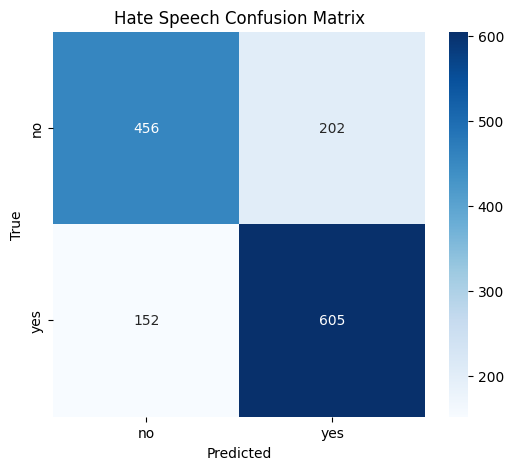

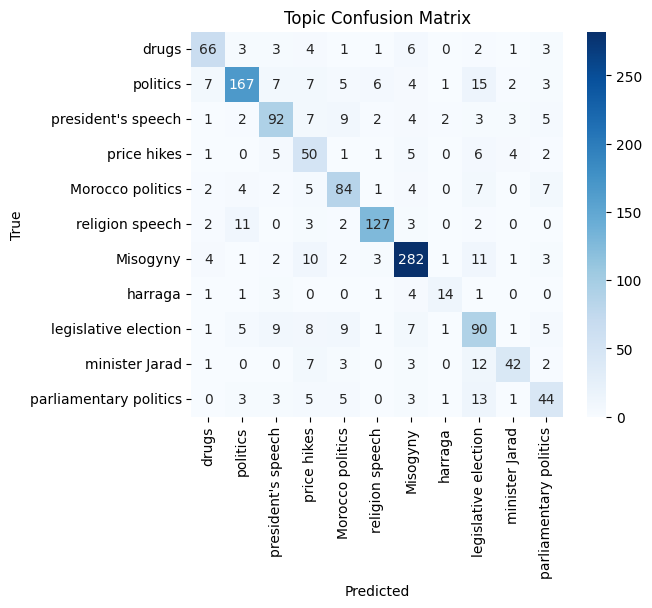

In [1]:
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, f1_score
from transformers import AutoTokenizer, AutoModel, get_scheduler
from torch.utils.data import Dataset, DataLoader
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


# 1️ Load and Preprocess Data

file_path = "/kaggle/input/accaurcy800/Algerian_Processed.xlsx"
df = pd.read_excel(file_path)

# Map labels
df["Hate speech"] = df["Hate speech"].map({"yes": 1, "no": 0})
topics = df["Topic"].unique()
topic_to_id = {topic: i for i, topic in enumerate(topics)}
id_to_topic = {i: topic for topic, i in topic_to_id.items()}
df["Topic"] = df["Topic"].map(topic_to_id)

# Split dataset
train_texts, temp_texts, train_labels, temp_labels, train_topics, temp_topics = train_test_split(
    df["processed_comment"], df["Hate speech"], df["Topic"], test_size=0.2, random_state=42, stratify=df["Hate speech"]
)

val_texts, test_texts, val_labels, test_labels, val_topics, test_topics = train_test_split(
    temp_texts, temp_labels, temp_topics, test_size=0.5, random_state=42, stratify=temp_labels
)


# 2️Tokenization

model_name = "aubmindlab/bert-base-arabertv02-twitter"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_texts(texts):
    return tokenizer(list(texts), truncation=True, padding=True, max_length=192, return_tensors="pt")

train_encodings = tokenize_texts(train_texts)
val_encodings = tokenize_texts(val_texts)
test_encodings = tokenize_texts(test_texts)


# 3️ Custom Dataset

class HateSpeechDataset(Dataset):
    def __init__(self, encodings, hate_speech_labels, topic_labels):
        self.encodings = encodings
        self.hate_speech_labels = hate_speech_labels
        self.topic_labels = topic_labels

    def __len__(self):
        return len(self.hate_speech_labels)

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item["hate_speech_labels"] = torch.tensor(self.hate_speech_labels.iloc[idx], dtype=torch.long)
        item["topic_labels"] = torch.tensor(self.topic_labels.iloc[idx], dtype=torch.long)
        return item

train_dataset = HateSpeechDataset(train_encodings, train_labels, train_topics)
val_dataset = HateSpeechDataset(val_encodings, val_labels, val_topics)
test_dataset = HateSpeechDataset(test_encodings, test_labels, test_topics)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)


#  CNN-BERT Hybrid Model

class CNNBERTMultiTaskModel(nn.Module):
    def __init__(self, model_name, num_topics, num_filters=100, filter_sizes=[2,3,4]):
        super(CNNBERTMultiTaskModel, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.convs = nn.ModuleList([
            nn.Conv1d(in_channels=self.bert.config.hidden_size,
                      out_channels=num_filters,
                      kernel_size=fs)
            for fs in filter_sizes
        ])
        self.dropout = nn.Dropout(0.4)
        self.fc_shared = nn.Sequential(
            nn.Linear(num_filters * len(filter_sizes), 256),
            nn.GELU(),
            nn.LayerNorm(256),
            nn.Dropout(0.4)
        )
        self.hate_speech_classifier = nn.Linear(256, 2)
        self.topic_classifier = nn.Linear(256, num_topics)

    def forward(self, input_ids, attention_mask, token_type_ids=None, hate_speech_labels=None, topic_labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs.last_hidden_state
        x = x.permute(0, 2, 1)
        conv_outputs = [torch.relu(conv(x)).max(dim=2)[0] for conv in self.convs]
        x = torch.cat(conv_outputs, dim=1)
        x = self.dropout(x)
        x = self.fc_shared(x)
        hate_speech_logits = self.hate_speech_classifier(x)
        topic_logits = self.topic_classifier(x)

        loss = None
        if hate_speech_labels is not None and topic_labels is not None:
            hate_weights = torch.tensor([1.0, 1.2]).to(hate_speech_logits.device)
            hate_loss_fn = nn.CrossEntropyLoss(weight=hate_weights, label_smoothing=0.1)
            topic_loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
            hate_loss = hate_loss_fn(hate_speech_logits, hate_speech_labels)
            topic_loss = topic_loss_fn(topic_logits, topic_labels)
            loss = hate_loss + topic_loss

        return loss, hate_speech_logits, topic_logits

#  Train & Eval Functions

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
num_topics = len(topics)
model = CNNBERTMultiTaskModel(model_name, num_topics).to(device)

optimizer = AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
num_training_steps = len(train_loader) * 12
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

best_val_loss = float("inf")
early_stop_counter = 0
train_losses, val_losses = [], []

def train_epoch(model, loader):
    model.train()
    total_loss, correct_hate, correct_topic = 0, 0, 0

    for batch in loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        loss, hate_logits, topic_logits = model(**batch)

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()
        correct_hate += (hate_logits.argmax(1) == batch["hate_speech_labels"]).sum().item()
        correct_topic += (topic_logits.argmax(1) == batch["topic_labels"]).sum().item()

    return total_loss / len(loader), correct_hate / len(loader.dataset), correct_topic / len(loader.dataset)

def evaluate(model, loader):
    model.eval()
    total_loss, correct_hate, correct_topic = 0, 0, 0

    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            loss, hate_logits, topic_logits = model(**batch)

            total_loss += loss.item()
            correct_hate += (hate_logits.argmax(1) == batch["hate_speech_labels"]).sum().item()
            correct_topic += (topic_logits.argmax(1) == batch["topic_labels"]).sum().item()

    return total_loss / len(loader), correct_hate / len(loader.dataset), correct_topic / len(loader.dataset)


# Training Loop

for epoch in range(12):
    train_loss, train_acc_hate, train_acc_topic = train_epoch(model, train_loader)
    val_loss, val_acc_hate, val_acc_topic = evaluate(model, val_loader)

    print(f"Epoch {epoch+1}/12")
    print(f"Train Loss: {train_loss:.4f} | Hate Acc: {train_acc_hate:.4f} | Topic Acc: {train_acc_topic:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Hate Acc: {val_acc_hate:.4f} | Topic Acc: {val_acc_topic:.4f}")
    print("-" * 60)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        early_stop_counter = 0
        timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        torch.save(model.state_dict(), f"/kaggle/working/best_model_{timestamp}.pth")
        print("✅ Model saved successfully!")
    else:
        early_stop_counter += 1
        if early_stop_counter >= 3:
            print("🛑 Early stopping")
            break

# 7️ Test & Evaluation

def test_model(model, loader):
    model.eval()
    all_hate_preds, all_topic_preds = [], []
    all_hate_true, all_topic_true = [], []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            hate_labels = batch['hate_speech_labels'].to(device)
            topic_labels = batch['topic_labels'].to(device)

            _, hate_logits, topic_logits = model(input_ids, attention_mask)

            hate_preds = torch.argmax(hate_logits, dim=1)
            topic_preds = torch.argmax(topic_logits, dim=1)

            all_hate_preds.extend(hate_preds.cpu().numpy())
            all_topic_preds.extend(topic_preds.cpu().numpy())
            all_hate_true.extend(hate_labels.cpu().numpy())
            all_topic_true.extend(topic_labels.cpu().numpy())

    return all_hate_preds, all_hate_true, all_topic_preds, all_topic_true

def plot_conf_matrix(y_true, y_pred, title, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.show()

hate_preds, hate_true, topic_preds, topic_true = test_model(model, test_loader)

print("\n📌 F1-score (Hate Speech):", f1_score(hate_true, hate_preds, average='weighted'))
print("📌 F1-score (Topic):", f1_score(topic_true, topic_preds, average='weighted'))

print("\n=== Hate Speech Report ===")
print(classification_report(hate_true, hate_preds, target_names=["no", "yes"]))
print("\n=== Topic Report ===")
print(classification_report(topic_true, topic_preds, target_names=[id_to_topic[i] for i in range(len(id_to_topic))]))

plot_conf_matrix(hate_true, hate_preds, "Hate Speech Confusion Matrix", ["no", "yes"])
plot_conf_matrix(topic_true, topic_preds, "Topic Confusion Matrix", [id_to_topic[i] for i in range(len(id_to_topic))])




In [2]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification

df = pd.read_excel('/kaggle/working/merged_dataset1.xlsx')  

model_name = "aubmindlab/bert-base-arabertv02-twitter" 
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()


topic_labels = ['misogyny', 'politics','racism','drugs', 'sports', 'religion', 'other']  


def predict_topic(text):
    inputs = tokenizer(text, truncation=True, padding=True, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class_id = logits.argmax(dim=-1).item()
    return topic_labels[predicted_class_id]


df['new_topic'] = df['text'].apply(predict_topic) 

output_path = '/kaggle/working/comments_with_topics1.xlsx'
df.to_excel(output_path, index=False)

print(f"✅ Done! Your dataset with topics is saved at {output_path}")


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/merged_dataset1.xlsx'

In [ ]:
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import AdamW
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from transformers import AutoTokenizer, AutoModel, get_scheduler
from torch.utils.data import Dataset, DataLoader
from datetime import datetime
import numpy as np

file_path = "/kaggle/input/krahttttttttt/merged_dataset.xlsx"
df = pd.read_excel(file_path)

df["label"] = df["label"].map({"yes": 1, "no": 0})
topics = df["predicted_topic"].unique()
topic_to_id = {topic: i for i, topic in enumerate(topics)}
df["predicted_topic"] = df["predicted_topic"].map(topic_to_id)

train_texts, temp_texts, train_labels, temp_labels, train_topics, temp_topics = train_test_split(
    df["text"], df["label"], df["predicted_topic"], 
    test_size=0.25, random_state=42, stratify=df["label"])
val_texts, test_texts, val_labels, test_labels, val_topics, test_topics = train_test_split(
    temp_texts, temp_labels, temp_topics, 
    test_size=0.5, random_state=42, stratify=temp_labels)

model_name = "alger-ia/dziribert"
tokenizer = AutoTokenizer.from_pretrained(model_name)

def tokenize_texts(texts):
    return tokenizer(list(texts), truncation=True, padding=True, max_length=128, return_tensors="pt")

train_encodings = tokenize_texts(train_texts)
val_encodings = tokenize_texts(val_texts)
test_encodings = tokenize_texts(test_texts)

class HateSpeechDataset(Dataset):
    def __init__(self, encodings, hate_speech_labels, topic_labels):
        self.encodings = encodings
        self.hate_speech_labels = hate_speech_labels
        self.topic_labels = topic_labels

    def __len__(self):
        return len(self.hate_speech_labels)

    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item["hate_speech_labels"] = torch.tensor(self.hate_speech_labels.iloc[idx], dtype=torch.long)
        item["topic_labels"] = torch.tensor(self.topic_labels.iloc[idx], dtype=torch.long)
        return item

train_dataset = HateSpeechDataset(train_encodings, train_labels, train_topics)
val_dataset = HateSpeechDataset(val_encodings, val_labels, val_topics)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False)

class CNNBERTMultiTaskModel(nn.Module):
    def __init__(self, model_name, num_topics, num_filters=100, filter_sizes=[2,3,4]):
        super(CNNBERTMultiTaskModel, self).__init__()
        self.bert = AutoModel.from_pretrained(model_name)
        self.convs = nn.ModuleList([
            nn.Conv1d(self.bert.config.hidden_size, num_filters, fs) for fs in filter_sizes
        ])
        self.dropout = nn.Dropout(0.5)
        self.fc_shared = nn.Linear(num_filters * len(filter_sizes), 256)
        self.hate_speech_classifier = nn.Linear(256, 2)
        self.topic_classifier = nn.Linear(256, num_topics)

    def forward(self, input_ids, attention_mask, token_type_ids=None, hate_speech_labels=None, topic_labels=None):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        x = outputs.last_hidden_state.permute(0, 2, 1)
        conv_outputs = [torch.relu(conv(x)).max(dim=2)[0] for conv in self.convs]
        x = torch.cat(conv_outputs, dim=1)
        x = self.dropout(x)
        x = self.fc_shared(x)
        hate_speech_logits = self.hate_speech_classifier(x)
        topic_logits = self.topic_classifier(x)

        loss = None
        if hate_speech_labels is not None and topic_labels is not None:
            hate_loss = nn.CrossEntropyLoss(weight=hate_weights)(hate_speech_logits, hate_speech_labels)
            topic_loss = nn.CrossEntropyLoss(weight=topic_weights)(topic_logits, topic_labels)
            loss = hate_loss + topic_loss

        return loss, hate_speech_logits, topic_logits

num_topics = len(topics)

hate_weights = compute_class_weight('balanced', classes=[0,1], y=train_labels)
hate_weights = torch.tensor(hate_weights, dtype=torch.float).to("cuda")

topic_weights = compute_class_weight('balanced', classes=np.unique(train_topics), y=train_topics)
topic_weights = torch.tensor(topic_weights, dtype=torch.float).to("cuda")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CNNBERTMultiTaskModel(model_name, num_topics).to(device)

bert_params = list(model.bert.named_parameters())
cnn_params = list(model.named_parameters())[len(bert_params):]

optimizer = AdamW([
    {'params': [p for n, p in bert_params], 'lr': 1e-5},
    {'params': [p for n, p in cnn_params], 'lr': 5e-5}
], weight_decay=0.01)

num_training_steps = len(train_loader) * 8
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=0, num_training_steps=num_training_steps)

def train_epoch(model, loader):
    model.train()
    total_loss, correct_hate, correct_topic = 0, 0, 0
    for batch in loader:
        batch = {k: v.to(device) for k, v in batch.items()}
        loss, hate_logits, topic_logits = model(**batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

        total_loss += loss.item()
        correct_hate += (hate_logits.argmax(1) == batch["hate_speech_labels"]).sum().item()
        correct_topic += (topic_logits.argmax(1) == batch["topic_labels"]).sum().item()

    return total_loss / len(loader), correct_hate / len(loader.dataset), correct_topic / len(loader.dataset)

def evaluate(model, loader):
    model.eval()
    total_loss, correct_hate, correct_topic = 0, 0, 0
    with torch.no_grad():
        for batch in loader:
            batch = {k: v.to(device) for k, v in batch.items()}
            loss, hate_logits, topic_logits = model(**batch)
            total_loss += loss.item()
            correct_hate += (hate_logits.argmax(1) == batch["hate_speech_labels"]).sum().item()
            correct_topic += (topic_logits.argmax(1) == batch["topic_labels"]).sum().item()

    return total_loss / len(loader), correct_hate / len(loader.dataset), correct_topic / len(loader.dataset)

best_val_loss = float('inf')
patience = 2
counter = 0

for epoch in range(8):
    train_loss, train_acc_hate, train_acc_topic = train_epoch(model, train_loader)
    val_loss, val_acc_hate, val_acc_topic = evaluate(model, val_loader)

    print(f"Epoch {epoch+1}/8")
    print(f"Train Loss: {train_loss:.4f} | Hate Acc: {train_acc_hate:.4f} | Topic Acc: {train_acc_topic:.4f}")
    print(f"Val Loss: {val_loss:.4f} | Hate Acc: {val_acc_hate:.4f} | Topic Acc: {val_acc_topic:.4f}")
    print("-" * 60)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        counter += 1
        if counter >= patience:
            print("🛑 Early stopping")
            break

timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
torch.save(model.state_dict(), f"/kaggle/working/cnn_dziribert_multitask_{timestamp}.pth")
print("✅ Model saved successfully!")